In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [2]:
def sigmoid(x, derivative=False):
    x = np.asarray(x, dtype=np.float64)
    val = 1 / (1 + np.exp(-x))
    if derivative:
        return val * (1 - val)
    else:
        return val

def tanh(x, derivative=False):
    x = np.asarray(x, dtype=np.float64)
    val = np.tanh(x)
    if derivative:
        return 1 - np.square(val)
    else:
        return val

def relu(x, derivative=False):
    # x = np.asarray(x, dtype=np.float64)
    if derivative:
        return np.where(x > 0, 1, 0)
    else:
        return np.maximum(0, x)

In [3]:
def mse(y_pred, y_true):
    """Mean Squared Error"""
    return np.mean(np.square(y_pred - y_true))

def rmse(y_pred, y_true):
    """Root Mean Squared Error"""
    return np.sqrt(mse(y_pred, y_true))

def r2_score(y_pred, y_true):
    """Compute R² Score safely"""
    ss_total = np.sum(np.square(y_true - np.mean(y_true)))
    ss_residual = np.sum(np.square(y_true - y_pred))

    # Handle case where variance in y_true is zero
    if ss_total == 0:
        return 0.0  # If all y_true are the same, return 0 R²

    return 1 - (ss_residual / ss_total)

In [4]:
def train_sgd(model, X, y, learning_rate):
        m = X.shape[0]
        indices = np.random.permutation(m)
        total_loss = 0

        for i in indices:
            X_batch = X[i:i+1]
            y_batch = y[i:i+1]
            total_loss += train_step(model, X_batch, y_batch, learning_rate)

        return total_loss/m

def train_minibatch(model, X, y, learning_rate, batch_size):
        """ Mini-batch Gradient Descent: Updates weights after each mini-batch """
        m = X.shape[0]
        indices = np.random.permutation(m)

        X_shuffled = X[indices]
        y_shuffled = y[indices]

        total_loss = 0
        num_batches = 0

        for i in range(0, m, batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            total_loss += train_step(model, X_batch, y_batch, learning_rate)  # Use returned loss
            num_batches += 1

        return total_loss / num_batches

def train_batch(model, X, y, learning_rate):
        m = X.shape[0]
        indices = np.random.permutation(m)

        X_shuffled = X[indices]
        y_shuffled = y[indices]
        return train_step(model, X_shuffled, y_shuffled, learning_rate)

def train_step(model, X_batch, y_batch, learning_rate):
        """ Performs forward, backward pass and updates weights """
        y_pred = model.forward(X_batch)
        loss = mse(y_pred, y_batch)
        grads_w, grads_b = model.backward(X_batch, y_batch)

        for i in range(len(model.weights)):

            model.weights[i] -= learning_rate * grads_w[i]
            model.biases[i] -= learning_rate * grads_b[i]

        return loss

In [15]:
class MLP_scratch:
    def __init__(self, input_size, hidden_layers, output_size, activation='relu', optimizer='minibatchgd', learning_rate=0.01, batch_size=None):
        self.layers = [input_size] + hidden_layers + [output_size]
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.weights = []
        self.biases = []
        self.losses = []
        for i in range(len(self.layers) - 1):
            layer_input_size = self.layers[i]
            layer_output_size = self.layers[i + 1]
            
            weight_matrix = np.random.randn(layer_input_size, layer_output_size) * 0.1


            bias = np.zeros((1, layer_output_size), dtype=np.float64)
            
            self.weights.append(weight_matrix)
            self.biases.append(bias)

        activation_funs = {'sigmoid': sigmoid, 'tanh': tanh, 'relu': relu}
        self.activation = activation_funs[activation]

        self.learning_rate = learning_rate

    def forward(self, X):
        if X.ndim == 1:
            X = X.reshape(1, -1)  # Reshape 1D array to 2D
        self.a = [X]
        self.z_values = []

        
        for i in range(len(self.weights)):
            W = self.weights[i]
            b = self.biases[i]
            prev_a = self.a[-1]
            
            z = np.dot(prev_a, W) + b
            self.z_values.append(z)

            if i < len(self.weights) - 1:
                activation_output = self.activation(z)
            else:
                activation_output = z
            
            self.a.append(activation_output)

        return self.a[-1]

    def backward(self, X, y):
        m = X.shape[0]
        grads_w = [np.zeros_like(w) for w in self.weights]
        grads_b = [np.zeros_like(b) for b in self.biases]

        dz = 2 * (self.a[-1] - y)/m

        for i in reversed(range(len(self.weights))):
            W = self.weights[i]
            a_prev = self.a[i]

            dw = np.dot(a_prev.T, dz)/m
            db = np.sum(dz, axis=0, keepdims=True)/m

            grads_w[i] = dw
            grads_b[i] = db

            if i > 0:
                dz = np.dot(dz, W.T) * self.activation(self.z_values[i-1], derivative=True)

        return grads_w, grads_b
    
    def train(self, X, y, epochs=100):
        X = X.astype(np.float64)  # Ensure training data is float64
        y = y.astype(np.float64)
        for epoch in range(epochs):
            if self.optimizer == 'sgd':
                # print("sgd")
                loss_val = train_sgd(self, X, y, self.learning_rate)
            elif self.optimizer == 'minibatchgd':
                # print("mini")
                loss_val = train_minibatch(self, X, y, self.learning_rate, self.batch_size)
            elif self.optimizer == 'batchgd':
                # print("whole")
                loss_val = train_batch(self, X, y, self.learning_rate)
            self.losses.append(loss_val)
            # print(f'Epoch {epoch}, Loss: {loss_val:.4f}')


        plt.plot(range(1, epochs+1), self.losses, marker='o', linestyle='-')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Epoch vs Loss")
        plt.grid()
        plt.show()

    def predict(self, X):
        """Predict method to get model's predictions"""
        return self.forward(X)

In [7]:
def test_model(model, X_test, y_test):
    # Ensure y_test is reshaped correctly if it’s 1D
    if y_test.ndim == 1:
        y_test = y_test.values.reshape(-1, 1)

    # Make predictions using the trained model
    y_pred = model.predict(X_test)

    # print("Predicted (Original Scale):", y_pred[:5].flatten())
    # print("Actual (Original Scale):", y_test[:5].flatten())

    mse_val = mse(y_test, y_pred)
    rmse_val = np.sqrt(mse_val)
    r2 = r2_score(y_pred, y_test)

    print(f"MSE: {mse_val:.4f}")
    print(f"RMSE: {rmse_val:.4f}")
    print(f"R² Score: {r2:.4f}")

    return mse_val, rmse_val, r2

In [8]:
def preprocess_data(X_train, X_test, X_valid):
    categorical_cols = ['area_type', 'availability', 'location', 'size']
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    
    # Fit on training data and transform all datasets
    X_train_encoded = encoder.fit_transform(X_train[categorical_cols])
    X_test_encoded = encoder.transform(X_test[categorical_cols])
    X_valid_encoded = encoder.transform(X_valid[categorical_cols])
    
    # Convert to DataFrame
    X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(categorical_cols), index=X_train.index)
    X_test_encoded = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(categorical_cols), index=X_test.index)
    X_valid_encoded = pd.DataFrame(X_valid_encoded, columns=encoder.get_feature_names_out(categorical_cols), index=X_valid.index)
    
    # Drop original categorical columns and concatenate encoded ones
    X_train = X_train.drop(columns=categorical_cols).reset_index(drop=True)
    X_test = X_test.drop(columns=categorical_cols).reset_index(drop=True)
    X_valid = X_valid.drop(columns=categorical_cols).reset_index(drop=True)

    X_train_encoded = pd.concat([X_train, X_train_encoded], axis=1)
    X_test_encoded = pd.concat([X_test, X_test_encoded], axis=1)
    X_valid_encoded = pd.concat([X_valid, X_valid_encoded], axis=1)
    
    return X_train_encoded, X_test_encoded, X_valid_encoded

In [9]:
def mlp_executive(epochs, hidden_layers_list, activation, optimizer, learning_rate, batch_size):
    np.random.seed(42)

    X_train = pd.read_csv("X_train.csv")
    y_train = pd.read_csv("y_train.csv").values.reshape(-1, 1)  # Ensure y_train is 2D

    X_valid = pd.read_csv("X_val.csv")
    y_valid = pd.read_csv("y_val.csv").values.reshape(-1, 1)

    X_test = pd.read_csv("X_test.csv")
    y_test = pd.read_csv("y_test.csv").values.reshape(-1, 1)  # Ensure y_test is 2D

    X_train_encoded, X_test_encoded, X_valid_encoded = preprocess_data(X_train, X_test, X_valid)

    # Initialize the MLP model
    input_size = X_train_encoded.shape[1]  # Number of features
    # hidden_layers_list = [512, 256]  # You can change this

    # print(X_train_encoded.columns)
    # print(hidden_layers_list)

    model = MLP_scratch(input_size=input_size, hidden_layers = hidden_layers_list, output_size=1, activation=activation, optimizer=optimizer, learning_rate=learning_rate, batch_size=batch_size)

    # Train the model
    model.train(X_train_encoded.values, y_train, epochs=epochs)

    print("For the validation set")
    test_model(model, X_valid_encoded.values, y_valid)

    # Test the model
    print("For the test set")
    test_model(model, X_test_encoded.values, y_test)

In [10]:
epochs = [5, 10, 20, 50]
for i in epochs:
    mlp_executive(i, [512, 256], 'relu', 'minibatchgd', 0.001, 64)

For the validation set
MSE: 949.4437
RMSE: 30.8130
R² Score: 0.2026
For the test set
MSE: 949.3015
RMSE: 30.8107
R² Score: 0.1963
For the validation set
MSE: 799.3791
RMSE: 28.2733
R² Score: 0.3287
For the test set
MSE: 800.3581
RMSE: 28.2906
R² Score: 0.3224
For the validation set
MSE: 615.9316
RMSE: 24.8180
R² Score: 0.4827
For the test set
MSE: 623.6116
RMSE: 24.9722
R² Score: 0.4720
For the validation set
MSE: 479.3581
RMSE: 21.8942
R² Score: 0.5974
For the test set
MSE: 486.0546
RMSE: 22.0466
R² Score: 0.5885


In [12]:
hidden_layers = [[10, 10], [256, 32], [512, 256], [512, 256, 256]]
for i in hidden_layers:
    mlp_executive(20, i, 'relu', 'minibatchgd', 0.001, 64)

For the validation set
MSE: 724.2492
RMSE: 26.9119
R² Score: 0.3918
For the test set
MSE: 732.1153
RMSE: 27.0576
R² Score: 0.3802
For the validation set
MSE: 667.3624
RMSE: 25.8334
R² Score: 0.4395
For the test set
MSE: 673.8477
RMSE: 25.9586
R² Score: 0.4295
For the validation set
MSE: 615.9316
RMSE: 24.8180
R² Score: 0.4827
For the test set
MSE: 623.6116
RMSE: 24.9722
R² Score: 0.4720
For the validation set
MSE: 1135.4655
RMSE: 33.6967
R² Score: 0.0464
For the test set
MSE: 1135.6500
RMSE: 33.6994
R² Score: 0.0385


In [14]:
learning_rate = [0.02, 0.0001, 0.001, 0.01]
for i in learning_rate:
    mlp_executive(20, [512, 256], 'relu', 'minibatchgd', i, 64)

For the validation set
MSE: 4553.4964
RMSE: 67.4796
R² Score: -2.8242
For the test set
MSE: 4594.6758
RMSE: 67.7840
R² Score: -2.8901
For the validation set
MSE: 1133.0630
RMSE: 33.6610
R² Score: 0.0484
For the test set
MSE: 1131.5512
RMSE: 33.6385
R² Score: 0.0420
For the validation set
MSE: 615.9316
RMSE: 24.8180
R² Score: 0.4827
For the test set
MSE: 623.6116
RMSE: 24.9722
R² Score: 0.4720
For the validation set
MSE: 4041.9016
RMSE: 63.5760
R² Score: -2.3945
For the test set
MSE: 4104.2108
RMSE: 64.0641
R² Score: -2.4748


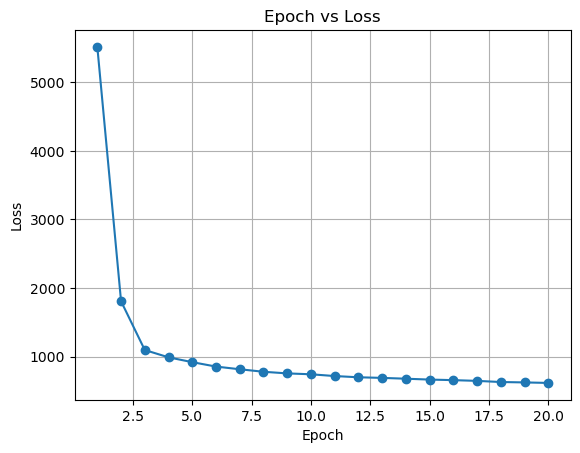

For the validation set
MSE: 615.9316
RMSE: 24.8180
R² Score: 0.4827
For the test set
MSE: 623.6116
RMSE: 24.9722
R² Score: 0.4720


In [17]:
mlp_executive(20, [512, 256], 'relu', 'minibatchgd', 0.001, 64)

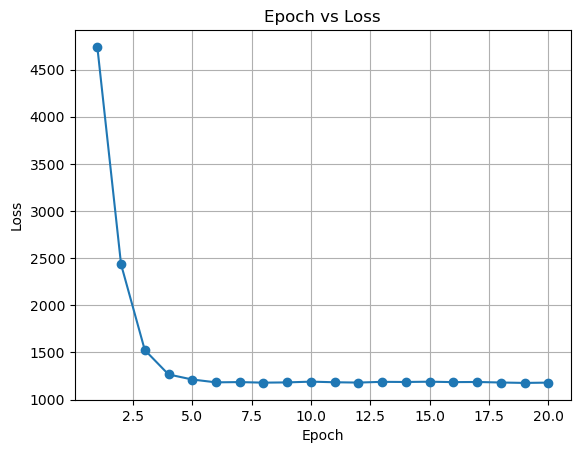

For the validation set
MSE: 1186.1034
RMSE: 34.4399
R² Score: 0.0039
For the test set
MSE: 1176.0813
RMSE: 34.2940
R² Score: 0.0043


In [18]:
mlp_executive(20, [512, 256], 'sigmoid', 'minibatchgd', 0.001, 64)

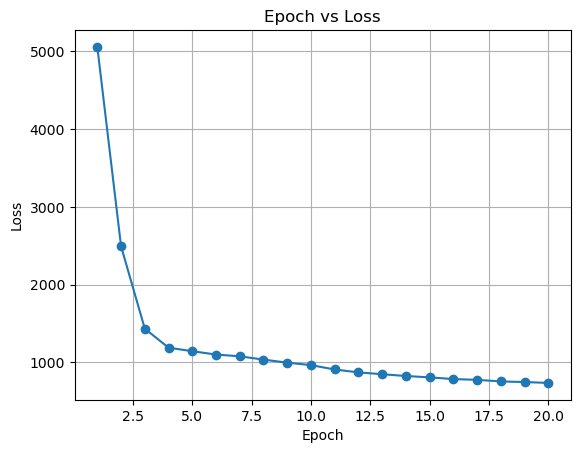

For the validation set
MSE: 719.8505
RMSE: 26.8300
R² Score: 0.3954
For the test set
MSE: 734.7723
RMSE: 27.1067
R² Score: 0.3779


In [19]:
mlp_executive(20, [512, 256], 'tanh', 'minibatchgd', 0.001, 64)

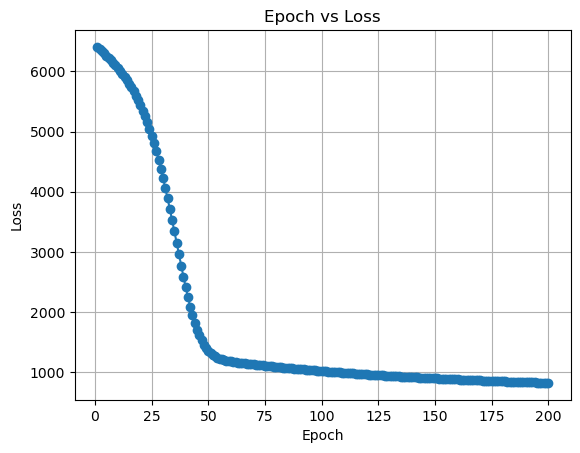

For the validation set
MSE: 823.3267
RMSE: 28.6937
R² Score: 0.3085
For the test set
MSE: 824.9448
RMSE: 28.7219
R² Score: 0.3016


In [20]:
mlp_executive(200, [512, 256], 'relu', 'batchgd', 0.5, 64)

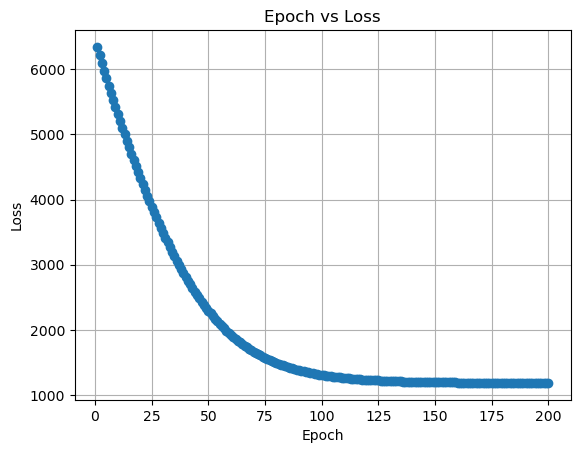

For the validation set
MSE: 1188.8885
RMSE: 34.4803
R² Score: 0.0015
For the test set
MSE: 1179.3250
RMSE: 34.3413
R² Score: 0.0015


In [21]:
mlp_executive(200, [512, 256], 'sigmoid', 'batchgd', 0.5, 64)

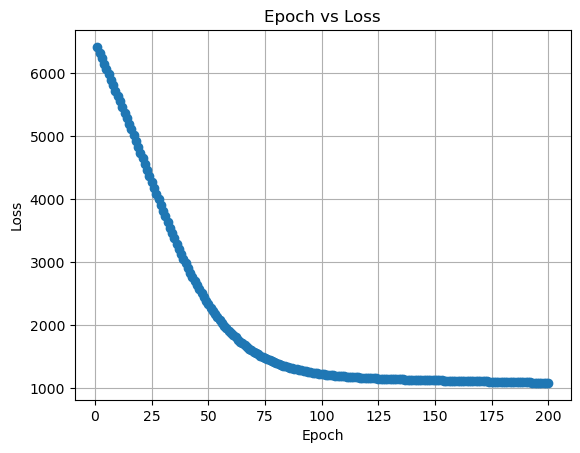

For the validation set
MSE: 1080.9300
RMSE: 32.8775
R² Score: 0.0922
For the test set
MSE: 1074.5064
RMSE: 32.7797
R² Score: 0.0903


In [22]:
mlp_executive(200, [512, 256], 'tanh', 'batchgd', 0.5, 64)

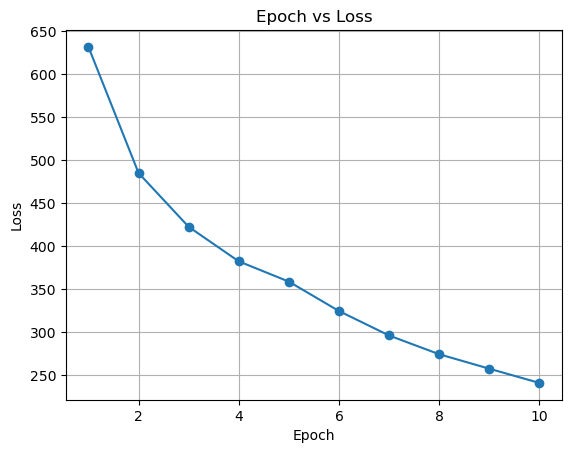

For the validation set
MSE: 365.7747
RMSE: 19.1252
R² Score: 0.6928
For the test set
MSE: 376.4761
RMSE: 19.4030
R² Score: 0.6813


In [23]:
mlp_executive(10, [512, 256], 'relu', 'sgd', 0.0001, 64)

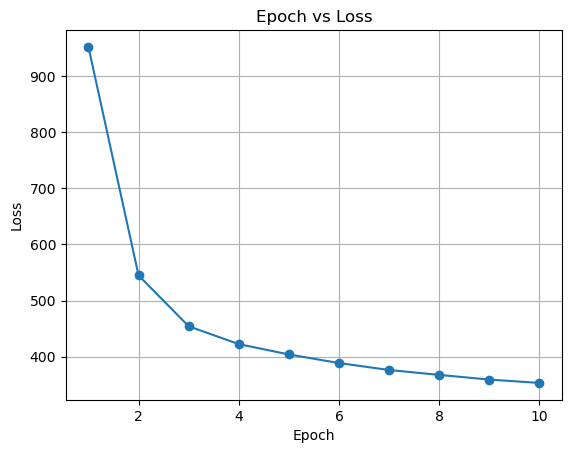

For the validation set
MSE: 384.9181
RMSE: 19.6193
R² Score: 0.6767
For the test set
MSE: 390.7595
RMSE: 19.7676
R² Score: 0.6692


In [24]:
mlp_executive(10, [512, 256], 'sigmoid', 'sgd', 0.0001, 64)

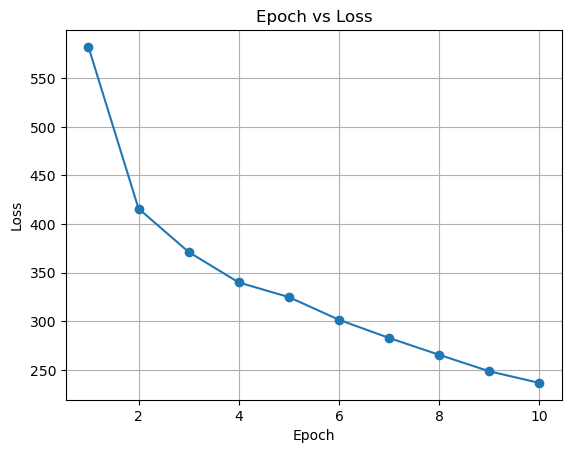

For the validation set
MSE: 366.3813
RMSE: 19.1411
R² Score: 0.6923
For the test set
MSE: 373.1832
RMSE: 19.3179
R² Score: 0.6840


In [25]:
mlp_executive(10, [512, 256], 'tanh', 'sgd', 0.0001, 64)

The combination "SGD", "tanh" is performing very good, the MSE value is least for this combination among all with value 373.1832 for the test set and then stands the "SGD", "relu" combination with not much difference. The value of MSE for "SGD", "relu" is 376.4761

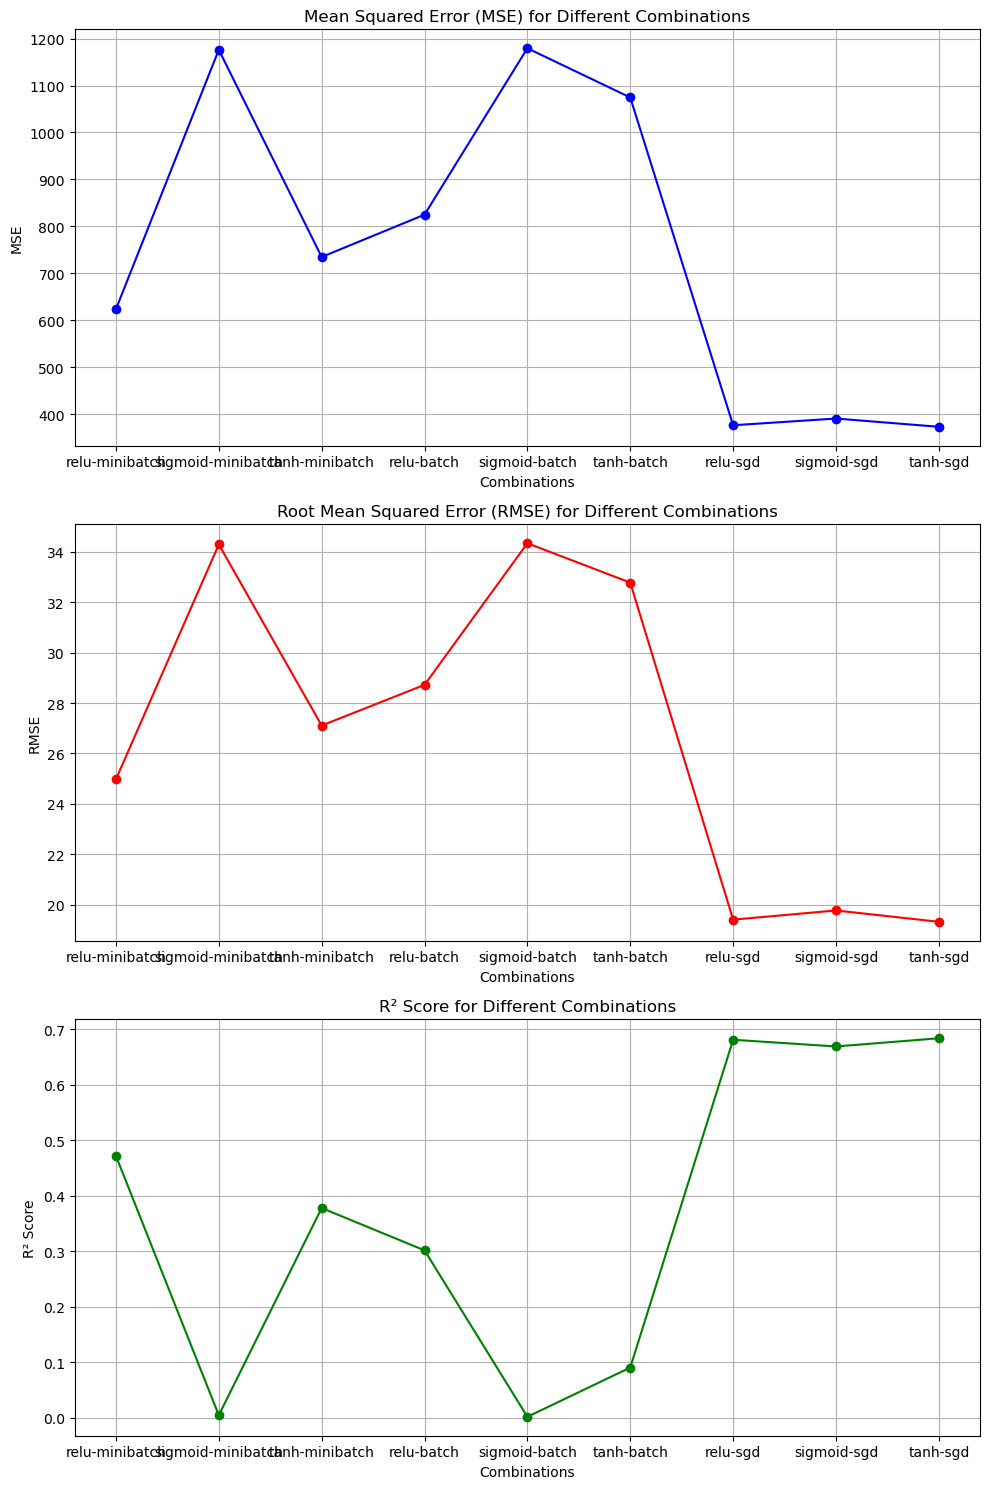

In [1]:
import matplotlib.pyplot as plt

# Data for the metrics
combinations = ['relu-minibatch', 'sigmoid-minibatch', 'tanh-minibatch', 
                'relu-batch', 'sigmoid-batch', 'tanh-batch', 
                'relu-sgd', 'sigmoid-sgd', 'tanh-sgd']

mse_values = [623.6116, 1176.0813, 734.7723, 824.9448, 1179.3250, 1074.5064, 376.4761, 390.7595, 373.1832]
rmse_values = [24.9722, 34.2940, 27.1067, 28.7219, 34.3413, 32.7797, 19.4030, 19.7676, 19.3179]
r2_values = [0.4720, 0.0043, 0.3779, 0.3016, 0.0015, 0.0903, 0.6813, 0.6692, 0.6840]

# Create subplots for each metric
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

# Plot MSE
ax1.plot(combinations, mse_values, marker='o', color='b', label='MSE')
ax1.set_title('Mean Squared Error (MSE) for Different Combinations')
ax1.set_xlabel('Combinations')
ax1.set_ylabel('MSE')
ax1.grid(True)

# Plot RMSE
ax2.plot(combinations, rmse_values, marker='o', color='r', label='RMSE')
ax2.set_title('Root Mean Squared Error (RMSE) for Different Combinations')
ax2.set_xlabel('Combinations')
ax2.set_ylabel('RMSE')
ax2.grid(True)

# Plot R² Score
ax3.plot(combinations, r2_values, marker='o', color='g', label='R² Score')
ax3.set_title('R² Score for Different Combinations')
ax3.set_xlabel('Combinations')
ax3.set_ylabel('R² Score')
ax3.grid(True)

# Display the plot
plt.tight_layout()
plt.show()
